### Reference
- https://github.com/AashishGit/CNN/blob/master/CovNet1-without%20pooling%20layer.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os as os
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train = data.drop(['label'], axis = 1)

In [4]:
label = data.label

In [5]:
target = pd.get_dummies(label, columns=['label'], drop_first=False)

In [6]:
x_train,x_cv,y_train,y_cv = train_test_split(train,target,test_size = 0.2, random_state = 42)

In [9]:
## Reshaping the dataframe to image
x_arr = np.array(x_train)
x_cv_arr = np.array(x_cv)
X = x_arr.reshape(48000,28,28,1)
X_cv = x_cv_arr.reshape(12000,28,28,1)

In [10]:
def zero_pad(data, pad):
    data_pad = np.pad(data,((0,0),(pad,pad),(pad,pad),(0,0)), 'constant')
    
    return data_pad

In [11]:
def softmax_cost(out,y):
    eout = np.exp(out, dtype=np.float)  
    probs = eout/np.sum(eout, axis = 1)[:,None]
    
    p = np.sum(np.multiply(y,probs), axis = 1)
    prob_label = np.argmax(np.array(probs), axis = 1)    ## taking out the arguments of max values
    cost = -np.log(p)    ## (Only data loss. No regularised loss)
    
    return p,cost,probs,label

In [12]:
def conv_net(input_data, Y, W1, b1, theta3,bias3):
    
    ####Forward propagation
    
    ## Input shape
    m, n_Hi, n_Wi, n_Ci = input_data.shape
    
    
    l1 = len(W1)    
    
    (f, f, _) = W1[0].shape   
    pad = 1
    
    
    n_H1 = n_Hi+(2*pad)-f + 1
    n_W1 = n_Wi+(2*pad)-f + 1
   

    conv1 = np.zeros((m,n_H1,n_W1,l1))
    
    input_pad = zero_pad(input_data,pad)
    
    
    for i in range(0,m):                                                  
        for j in range(0,l1):                                             
            for x in range(0,n_H1):                                       
                for y in range(0,n_W1):                                   
                    conv1[i,x,y,j] = np.sum(input_pad[i,x:x+f,y:y+f]*W1[j])+b1[j]
        conv1[i,:,:,:][conv1[i,:,:,:] <= 0] = 0                           
        

    fc1 = conv1.reshape(m,int((n_H1)*(n_W1)*l1))
    
    out = np.dot(fc1,theta3) + bias3
        
    p, cost, probs, prob_label = softmax_cost(out, Y)   ## change it to y_train or batch
    
    acc = []
    for i in range(0,len(Y)):
        if prob_label[i]==np.argmax(np.array(Y)[i,:]):
            acc.append(1)
        else:
            acc.append(0)
    
    d_out = probs - Y

    dtheta3 = np.dot(d_out.T, fc1)
    dbias3 = np.mean(d_out, axis = 0).reshape(1,10)    

    dfc1 = np.dot(theta3,d_out.T)
    
    dconv1 = dfc1.T.reshape((m, int(n_H1), int(n_W1), l1))

    
    dW1_stack = {}
    db1_stack = {}
    
    dW1_stack = np.zeros((m,l1,f,f,1))
    db1_stack = np.zeros((m,l1,1))

    bW1 = {}
    dW1 = np.zeros((l1,f,f,1))
    db1 = np.zeros((l1,1))
    
    
    for i in range(0,m):            
        for c in range(0,l1):
            for x in range(0,n_H1):
                for y in range(0,n_W1):
                    dW1_stack[i,:,:,c] += dconv1[i,x,y,c]*input_pad[i,x:x+f,y:y+f,:]

            db1_stack[i,c] = np.sum(dconv1[i,:,:,c])
            
        dW1 = np.mean(dW1_stack, axis = 0)
        db1 = np.mean(db1_stack, axis = 0)

        
    return dW1, db1, dtheta3, dbias3, cost, probs, prob_label, acc

In [13]:
def optimizer(batch,learning_rate,W1,b1,theta3,bias3):
    
    X = batch[:,0:-10]
    X = X.reshape(len(batch), w, w, l)
    Y = batch[:,784:794]

    batch_size = len(batch)
    
    bW1 = {}
    dW1 = np.zeros((l1,f,f,1))
    db1 = np.zeros((l1,1))
    
    dtheta3 = np.zeros(theta3.shape)
    dbias3 = np.zeros(bias3.shape)
    
    grads = conv_net(X,Y,W1,b1,theta3,bias3)
    [dW1, db1, dtheta3, dbias3, cost_, probs_, prob_label, acc_] = grads
    
    W1 = W1-learning_rate*(dW1)
    b1 = b1-learning_rate*(db1)
    theta3 = theta3-learning_rate*(dtheta3.T)
    bias3 = bias3-learning_rate*(dbias3)
    
    batch_cost = np.mean(cost_)
    batch_accuracy = sum(acc_)/len(acc_)
    
    return W1, b1, theta3, bias3, batch_cost, acc_, batch_accuracy

In [14]:
W1 = 0.1*np.random.rand(3,3,3,1)
b1 = 0.1*np.random.rand(3,1)

theta3 = 0.1*np.random.rand(2352,10)
bias3 = 0.1*np.random.rand(1,10)

x_arr -= int(np.mean(x_arr))
x_arr = x_arr.astype(float)
x_arr /= int(np.std(x_arr))

train_data = np.hstack((x_arr,np.array(y_train))) 
t = train_data[0:320]      

x_cv_arr -= int(np.mean(x_cv_arr))
x_cv_arr = x_cv_arr.astype(float)
x_cv_arr /= int(np.std(x_cv_arr))

cv_data = np.hstack((x_cv_arr,np.array(y_cv)))

test_data = x_cv_arr[0:100]      

Y_cv = np.array(y_cv)[0:100]

np.random.shuffle(train_data)

learning_rate = 0.001
batch_size = 32
num_epochs = 10
num_images = len(t) 
w = 28
l = 1
l1 = len(W1)  
f = len(W1[0]) 

In [15]:
def main_init(train_data,W1,b1,theta3,bias3):
    cost = []
    accuracy = []
    for epoch in range(0, num_epochs):
        batches = [train_data[k:k + batch_size] for k in range(0, len(train_data), batch_size)]
        x=0
        i = 1
        for batch in batches:
            
            output = optimizer(batch,learning_rate,W1,b1,theta3,bias3)
            [W1, b1, theta3, bias3, batch_cost,acc_,batch_acc] = output
            
            
            cost.append(batch_cost)
            accuracy.append(batch_acc)

            print ('ep:%d, batch_num = %f, batch_cost = %f, batch_acc = %f' %(epoch,i,batch_cost,batch_acc)) 
            i+=1
    return W1,b1,theta3,bias3,cost,accuracy

ep:0, batch_num = 1.000000, batch_cost = 2.355397, batch_acc = 0.187500
ep:0, batch_num = 2.000000, batch_cost = 2.289821, batch_acc = 0.125000
ep:0, batch_num = 3.000000, batch_cost = 1.992886, batch_acc = 0.312500
ep:0, batch_num = 4.000000, batch_cost = 1.835800, batch_acc = 0.343750
ep:0, batch_num = 5.000000, batch_cost = 1.992097, batch_acc = 0.375000
ep:0, batch_num = 6.000000, batch_cost = 1.898046, batch_acc = 0.406250
ep:0, batch_num = 7.000000, batch_cost = 1.614997, batch_acc = 0.531250
ep:0, batch_num = 8.000000, batch_cost = 1.578523, batch_acc = 0.656250
ep:0, batch_num = 9.000000, batch_cost = 1.647839, batch_acc = 0.593750
ep:0, batch_num = 10.000000, batch_cost = 1.502046, batch_acc = 0.625000
ep:1, batch_num = 1.000000, batch_cost = 1.537722, batch_acc = 0.593750
ep:1, batch_num = 2.000000, batch_cost = 1.299085, batch_acc = 0.718750
ep:1, batch_num = 3.000000, batch_cost = 1.160947, batch_acc = 0.875000
ep:1, batch_num = 4.000000, batch_cost = 1.078016, batch_acc = 

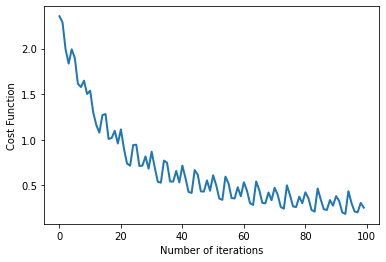

In [16]:
W1_t,b1_t,theta3_t,bias3_t,cost_t,accuracy_t = main_init(t,W1,b1,theta3,bias3)
plt.plot(cost_t, linewidth = 2)
plt.ylabel('Cost Function')
plt.xlabel('Number of iterations')
plt.show()